## Start

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

In [7]:
import xarray as xr
print(xr.backends.plugins.list_engines())

/home/giuseppe/pmts/pmts_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'pyrregular': <IrregularEntrypoint>, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


In [8]:
# setup.py or pyproject.toml (by maintainers of pyrregular)
entry_points={
    'xarray.backends': ['pyrregular = pyrregular.backend:PyrregularBackendEntrypoint'],
}


## Loading the dataset

In [9]:
import os
dataset_path = os.path.join(
    os.getcwd(),
    "data",
    "PMTSA_2025.h5"
)
df = xr.load_dataset(dataset_path, engine="pyrregular")["data"]
df


Format,coo
Data Type,float64
Shape,"(40334, 34, 336)"
nnz,10486913
Density,0.02275926206997898
Read-only,True
Size,320.0M
Storage ratio,0.09


In [10]:
# the shape is (n_time_series, n_channels, n_timestamps)
df.shape

(40334, 34, 336)

In [11]:
# the array is stored as a sparse array
df.data

Format,coo
Data Type,float64
Shape,"(40334, 34, 336)"
nnz,10486913
Density,0.02275926206997898
Read-only,True
Size,320.0M
Storage ratio,0.09


### Some plots

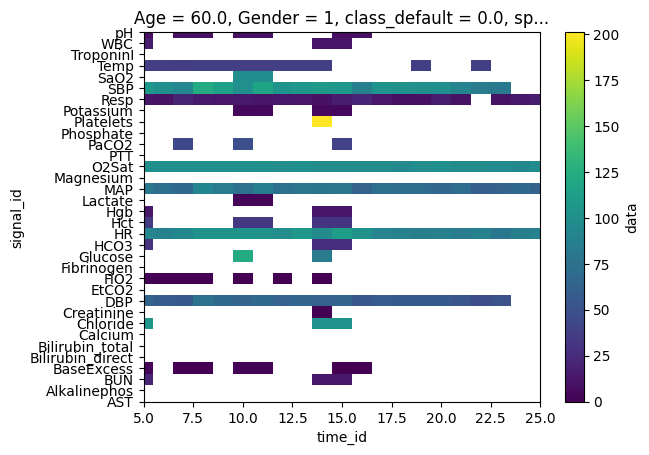

In [12]:
# plotting an entire multivariate time series
df.irr[1].plot()

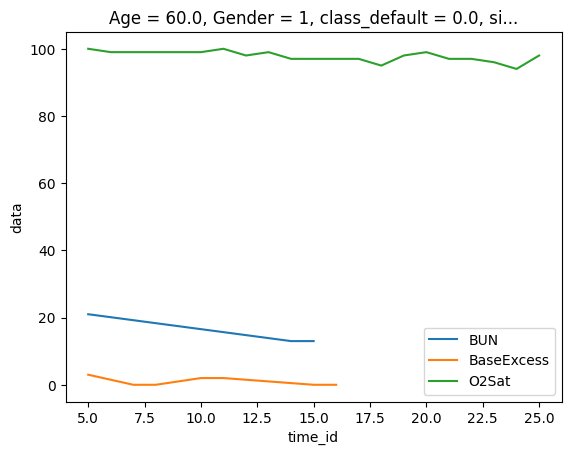

In [13]:
# plotting some channels
df.irr[1, 2].plot(label=df.coords["signal_id"][2].item())
df.irr[1, 3].plot(label=df.coords["signal_id"][3].item())
df.irr[1, 21].plot(label=df.coords["signal_id"][21].item())
plt.legend()

## Converting to dense

In [14]:
%%time
# time series data
X, _ = df.irr.to_dense()

CPU times: user 8.81 s, sys: 698 ms, total: 9.51 s
Wall time: 8.83 s


In [15]:
# static variables
Z = df.coords.to_dataset()[["Age", "Gender"]].to_pandas()
Z.head()

,Age,Gender,class_default,split_default
ts_id,,,,
0,70.0,1,NaN,test
1,60.0,1,0.0,train
2,80.0,0,NaN,test
3,30.0,1,0.0,train
4,70.0,0,0.0,train


In [16]:
# target and split
y, split = df.irr.get_task_target_and_split()

### Train-test split

In [17]:
X_train, X_test = X[split != "test"], X[split == "test"]
y_train, y_test = y[split != "test"], y[split == "test"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20336, 34, 334), (20336,), (19998, 34, 334), (19998,))

In [18]:
test_id = df["ts_id"][split == "test"].data

## Hyperpars for preprocess

In [19]:
threshold_channels = 90  # 91 (leave out the channels with more than 91% of missing values)
cutoff_timestamps = 50  # 13 (leave out all the timestamps after 13)
threshold_samples = 90  # 20 (leave out the samples with more than 20% of missing values)

## Preprocessing

### Libraries

In [60]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sktime.transformations.series.impute import Imputer

### Check class labels

In [61]:
type(y_train)

numpy.ndarray

In [62]:
print("y_train:")
print(np.unique(y_train, return_counts=True), "\n")

print("y_train labels percentage:")
print(np.unique(y_train, return_counts=True)[1] / len(y_train) * 100)

y_train:
(array([0., 1.], dtype=float32), array([18546,  1790])) 

y_train labels percentage:
[91.19787569  8.80212431]


In [63]:
np.unique(y_test, return_counts=True)

(array([nan], dtype=float32), array([19998]))

In [64]:
# Encode the labels
le = LabelEncoder()
y_train_labelled = le.fit_transform(y_train)

y_train_labelled:
(array([0, 1]), array([18546,  1790])) 

y_train_labelled percentage:
[91.19787569  8.80212431]


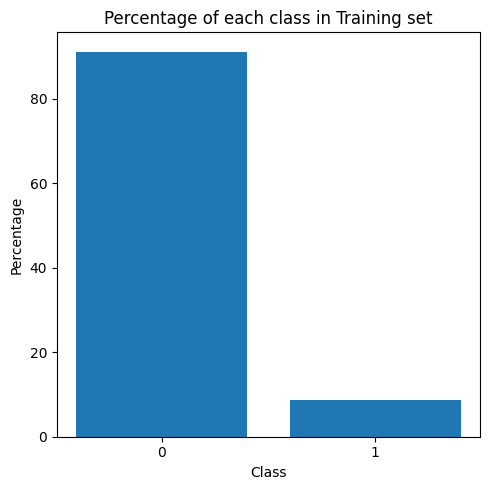

In [65]:
print("y_train_labelled:")
print(np.unique(y_train_labelled, return_counts=True), "\n")
print("y_train_labelled percentage:")
print(np.unique(y_train_labelled, return_counts=True)[1] / len(y_train_labelled) * 100)

plt.figure(figsize=(5, 5))
plt.bar(
    np.unique(y_train_labelled),
    np.unique(y_train_labelled, return_counts=True)[1] / len(y_train_labelled) * 100,
)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(
    np.arange(len(np.unique(y_train_labelled))),
    np.unique(y_train_labelled),
)
plt.title("Percentage of each class in Training set")
plt.tight_layout()
plt.show()

### Check Input

In [66]:
type(X_train)

numpy.ndarray

In [67]:
print("Training data shape:")
print(X_train.shape)  # (n_samples, n_channels, n_timestamps)
print("Testing data shape:")
print(X_test.shape)  # (n_samples, n_channels, n_timestamps)

Training data shape:
(20336, 34, 334)
Testing data shape:
(19998, 34, 334)


### Some plots

In [68]:
label = df.coords["signal_id"].values
sample = 1

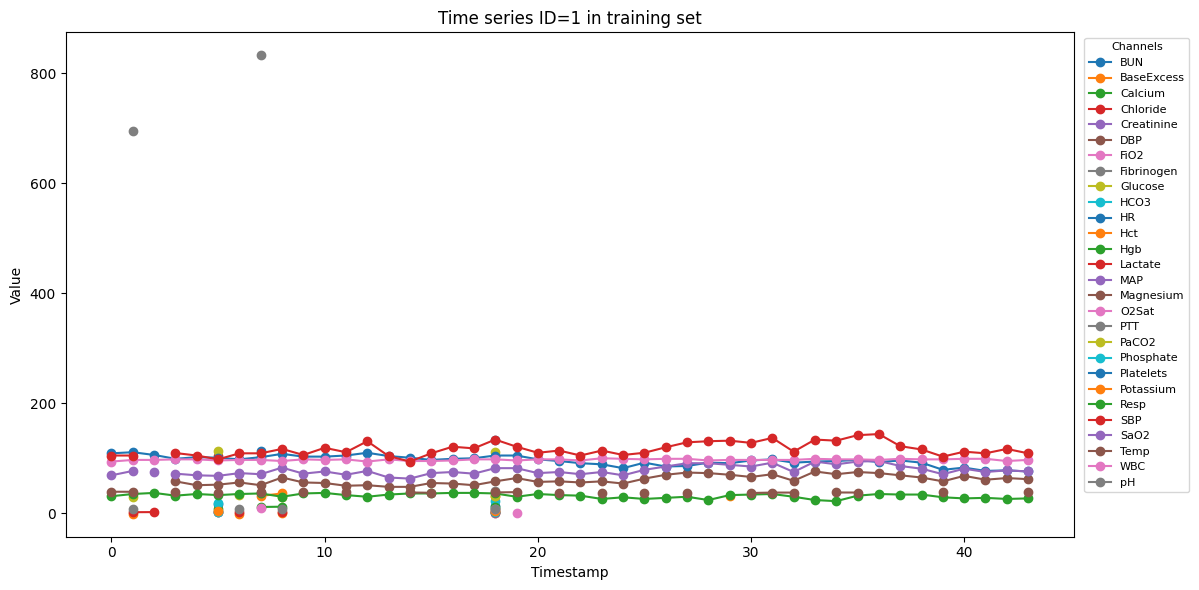

In [69]:
# Plot a time series
plt.figure(figsize=(12, 6))
# take the labels only if the channels are not empty
channel_index = ~np.isnan(X_train[sample, :, :]).all(axis=1)
plt.plot(X_train[sample, channel_index, :].T, marker="o", linestyle="-", label=label[channel_index])
plt.title(f"Time series ID={sample} in training set")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.12, 1),
    fontsize=8,
    title="Channels",
    title_fontsize=8
    )
plt.tight_layout()
plt.show()

In [70]:
# Total number of missing values
total_missing_values_train = np.sum(np.isnan(X_train))
total_missing_values_test = np.sum(np.isnan(X_test))
print("Total number of missing values in X_train:", total_missing_values_train)
print("Total number of missing values in X_test:", total_missing_values_test)
# Percentage of missing values
percentage_missing_values_train = total_missing_values_train / X_train.size * 100
percentage_missing_values_test = total_missing_values_test / X_test.size * 100
print("Percentage of missing values in X_train:", percentage_missing_values_train)
print("Percentage of missing values in X_test:", percentage_missing_values_test)

Total number of missing values in X_train: 225398767
Total number of missing values in X_test: 222147224
Percentage of missing values in X_train: 97.6024274228883
Percentage of missing values in X_test: 97.82028924977739


Percentage of missing values in samples:
[98.33568158 97.05882353 96.60091582 ... 97.05001761 99.18104967
 97.4462839 ]


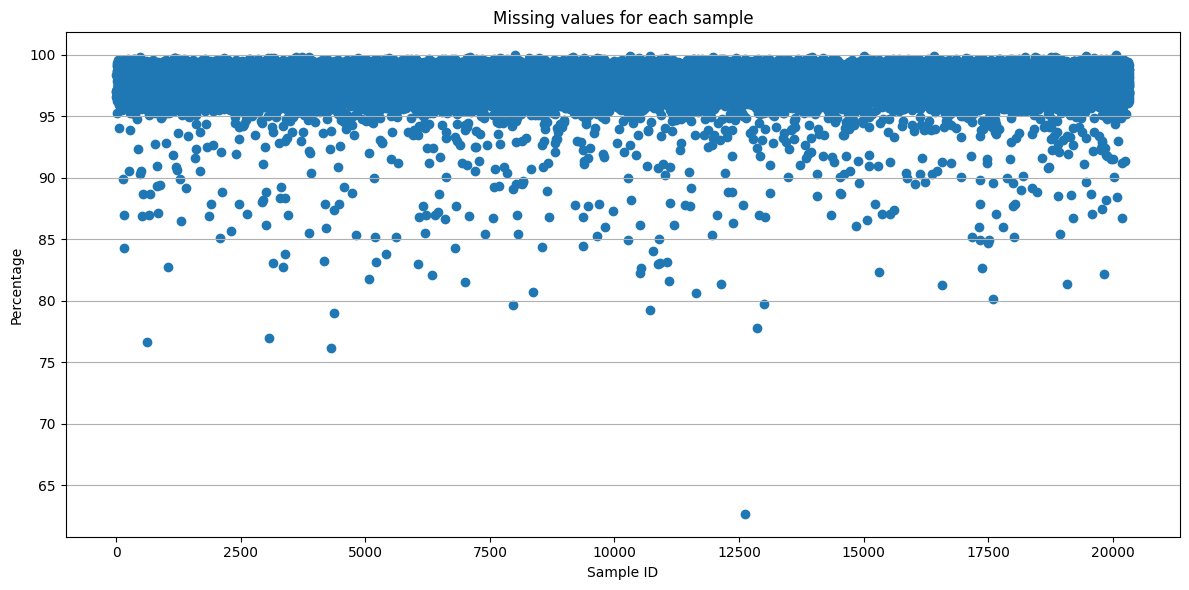

In [71]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train).sum(axis=(1,2))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train.shape[1] * X_train.shape[2])) * 100
print("Percentage of missing values in samples:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.scatter(
    np.arange(len(missing_percentage)),
    missing_percentage,
)
plt.grid(axis="y")
plt.xlabel("Sample ID")
plt.ylabel("Percentage")
plt.title("Missing values for each sample")
plt.tight_layout()
plt.show()

Percentage of missing values in chanels:
[ 99.82597747  99.83021761  99.05073802  98.78712775  99.98259775
  99.85729269  99.42113217  99.03158376  99.22724869  93.9648928
 100.          98.34877354  99.91122201  98.57696095  99.06338484
  89.26675563  98.62993329  98.97204509  99.60038126  89.55633678
  99.09483256  89.76570855  99.43603156  98.9798923   99.41262243
  99.24179473  98.73626076  89.50333499  90.13557268  99.42345835
  96.07049179  99.98579258  99.12623612  98.66590089]


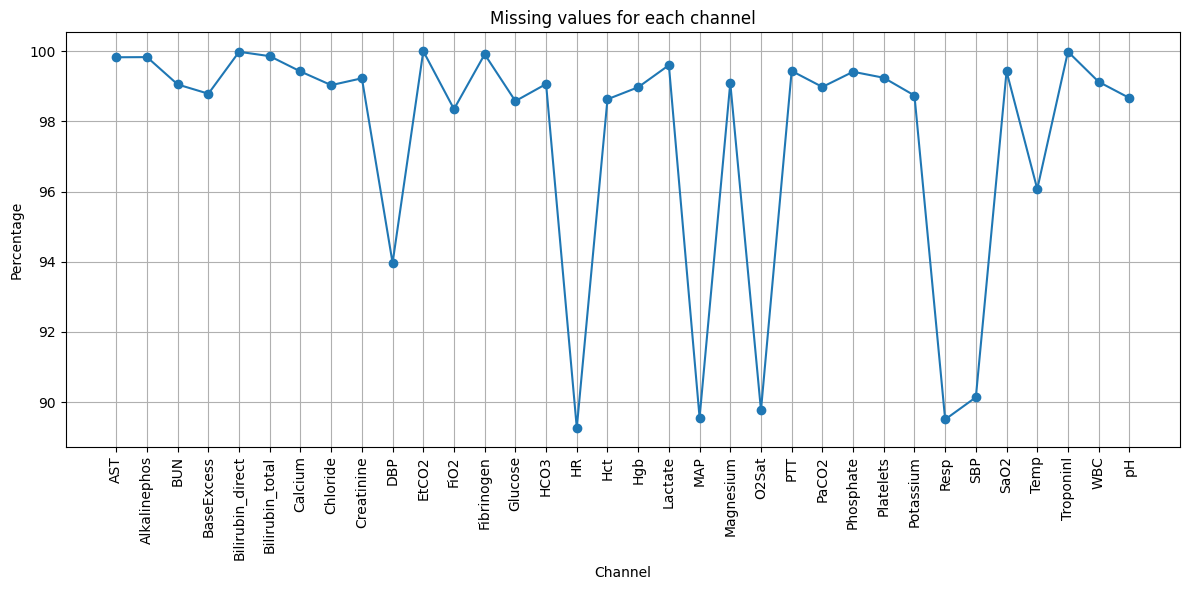

In [72]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train).sum(axis=(0,2))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train.shape[0] * X_train.shape[2])) * 100
print("Percentage of missing values in chanels:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.plot(missing_percentage, marker="o", linestyle="-")
plt.xlabel("Channel")
plt.xticks(np.arange(len(missing_percentage)), label, rotation=90)
plt.grid(axis="both")
plt.ylabel("Percentage")
plt.title("Missing values for each channel")
plt.tight_layout()
plt.show()

Percentage of missing values in timestamps:
[69.65870436 74.05181191 76.65021752 76.53191095 76.24858264 76.30643426
 76.26000833 76.83375179 77.3011929  77.48790901 78.14438029 78.2603728
 78.41266719 78.86289744 79.2464537  80.17526149 81.22440066 82.17967557
 82.66996807 83.1026982  83.64491253 84.1156801  84.66165479 84.96711135
 85.29874578 85.68591776 85.99846115 86.22928912 86.45201786 86.70786666
 86.884748   87.10689823 87.47873953 87.90380432 88.48087425 89.14197367
 89.84342458 90.44638312 91.26816541 91.98060814 92.7629067  93.39927454
 94.04229532 94.48384783 94.94825172 95.43984588 95.8416254  96.23978919
 96.64691998 97.004443   97.32624265 97.67913755 98.01149512 98.29250937
 98.53548619 98.78439279 99.02100592 99.18892026 99.27743324 99.30592516
 99.30997478 99.34974777 99.37549174 99.3608842  99.38662818 99.37549174
 99.39848776 99.42206229 99.40138034 99.41396307 99.41584325 99.42394247
 99.4185912  99.46660804 99.45619475 99.47094692 99.46501712 99.46733119
 99.4868

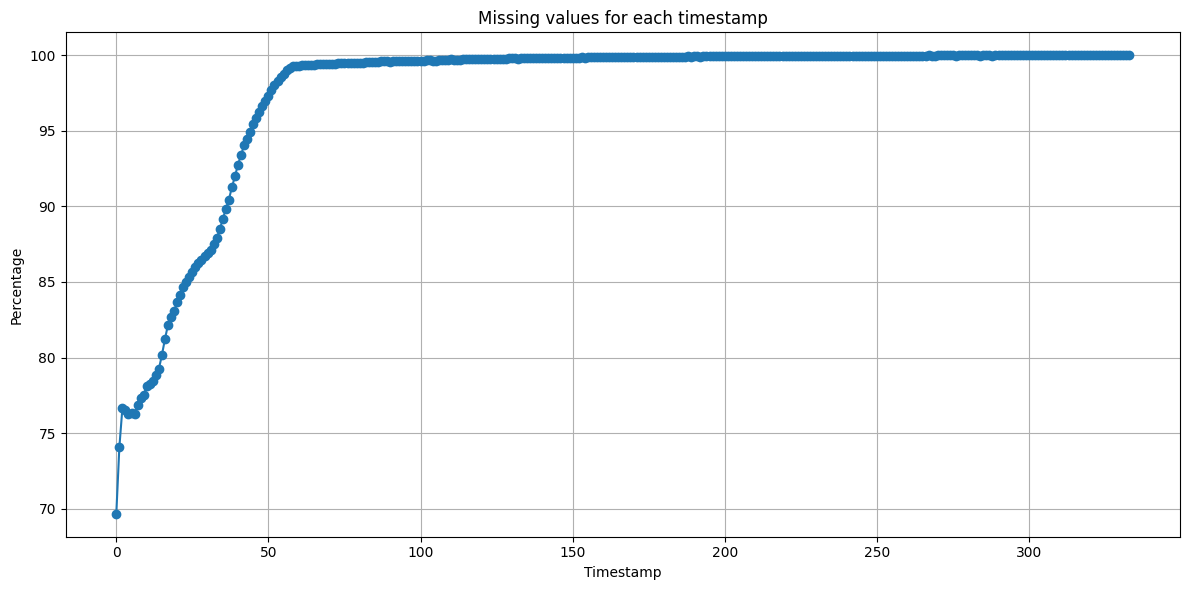

In [73]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train).sum(axis=(0,1))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train.shape[0] * X_train.shape[1])) * 100
print("Percentage of missing values in timestamps:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.plot(missing_percentage, marker="o", linestyle="-")
plt.grid(axis="both")
plt.xlabel("Timestamp")
plt.ylabel("Percentage")
plt.title("Missing values for each timestamp")
plt.tight_layout()
plt.show()

### Remove useless channels

Percentage of missing values in chanels:
[ 99.82597747  99.83021761  99.05073802  98.78712775  99.98259775
  99.85729269  99.42113217  99.03158376  99.22724869  93.9648928
 100.          98.34877354  99.91122201  98.57696095  99.06338484
  89.26675563  98.62993329  98.97204509  99.60038126  89.55633678
  99.09483256  89.76570855  99.43603156  98.9798923   99.41262243
  99.24179473  98.73626076  89.50333499  90.13557268  99.42345835
  96.07049179  99.98579258  99.12623612  98.66590089]


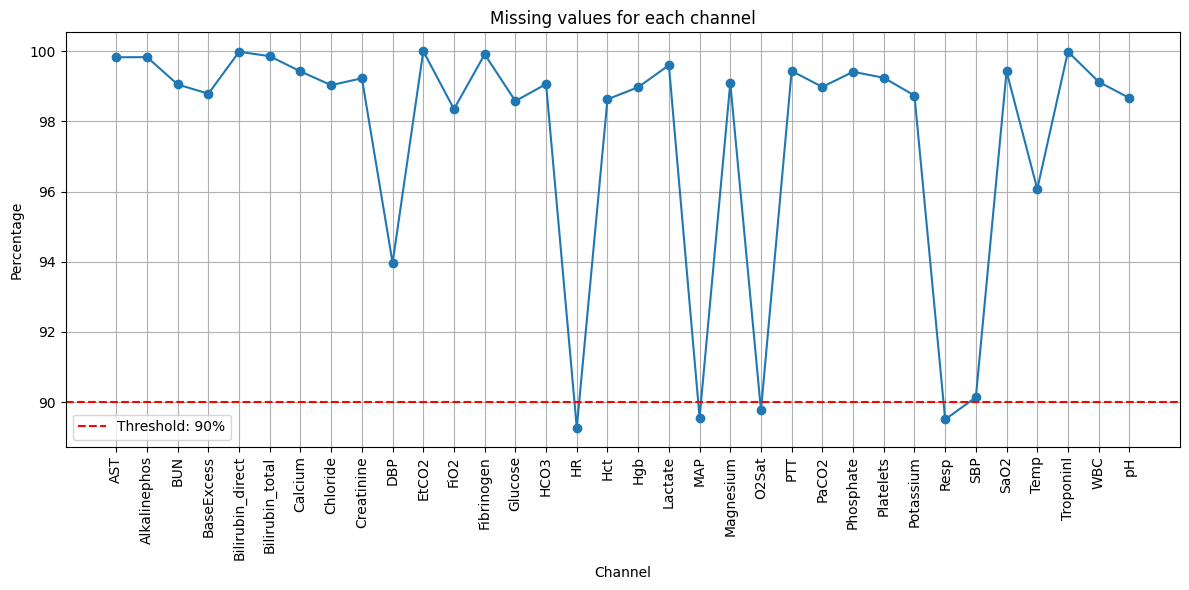

In [74]:
# Compute the nan counts for each timestamp
missing_channels = np.isnan(X_train).sum(axis=(0,2))
# Compute the percentage of missing values for each timestamp
missing_percentage_channels = (missing_channels / (X_train.shape[0] * X_train.shape[2])) * 100
print("Percentage of missing values in chanels:")
print(missing_percentage_channels)

# threshold_channels = 91

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.plot(missing_percentage_channels, marker="o", linestyle="-")
plt.axhline(y=threshold_channels, color="r", linestyle="--", label=f"Threshold: {threshold_channels}%")
plt.legend()
plt.xlabel("Channel")
plt.xticks(np.arange(len(missing_percentage_channels)), label, rotation=90)
plt.grid(axis="both")
plt.ylabel("Percentage")
plt.title("Missing values for each channel")
plt.tight_layout()
plt.show()

In [75]:
# Take the channels with less than 91% of missing values
X_train_masked_channels = X_train[:, missing_percentage_channels < threshold_channels, :]
X_test_masked_channels = X_test[:, missing_percentage_channels < threshold_channels, :]

In [76]:
print("Original Train data shape:")
print("Input: ", X_train.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape without useless channels:")
print("Input: ", X_train_masked_channels.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Original Test data shape:")
print("Input: ", X_test.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)
print("\n")
print("Test data shape without useless channels:")
print("Input: ", X_test_masked_channels.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)

Original Train data shape:
Input:  (20336, 34, 334)
Label:  (20336,)


Train data shape without useless channels:
Input:  (20336, 4, 334)
Label:  (20336,)


Original Test data shape:
Input:  (19998, 34, 334)
Label:  (19998,)


Test data shape without useless channels:
Input:  (19998, 4, 334)
Label:  (19998,)


Percentage of missing values in samples:
[93.78742515 86.9011976  87.9491018  ... 86.60179641 95.05988024
 88.99700599]


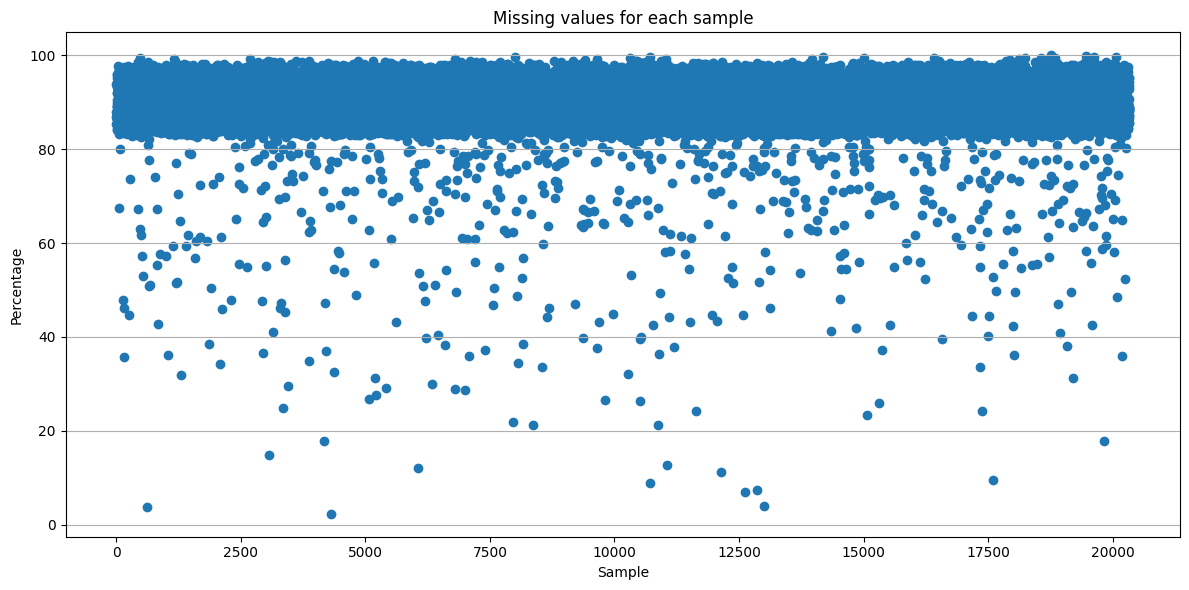

In [77]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train_masked_channels).sum(axis=(1,2))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train_masked_channels.shape[1] * X_train_masked_channels.shape[2])) * 100
print("Percentage of missing values in samples:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.scatter(
    np.arange(len(missing_percentage)),
    missing_percentage,
)
plt.xlabel("Sample")
plt.ylabel("Percentage")
plt.title("Missing values for each sample")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [78]:
label_masked_channels = label[missing_percentage_channels < threshold_channels]

Percentage of missing values in timestamps:
[ 2.78692958  3.20982494  3.3893096   3.48765736  3.38808025  3.51716168
  3.6536192   4.14289929  4.76371951  5.58861133  6.35449449  7.25929386
  8.29194532  9.54096184 10.65597954 12.22462628 13.97152832 15.87701613
 18.13532651 20.29283045 22.57081039 24.79469906 27.32838316 29.52276751
 31.33974233 33.21572581 34.92574744 36.44890834 37.82085956 39.122738
 40.40863493 41.71543076 43.14147325 44.9068155  47.35690401 50.58148112
 53.53928993 56.62740952 59.69094217 62.57621951 65.27217742 67.84397128
 70.55468135 73.04533832 75.51509638 78.03771637 80.30709087 82.3883753
 84.48932927 86.20672699 87.83192368 89.47924862 91.05527144 92.39280094
 93.7082022  94.89206334 95.86078875 96.59839693 96.99670535 97.06309009
 97.09259441 97.17619001 97.24626279 97.28928993 97.3015834  97.31141817
 97.33723446 97.38763769 97.43558222 97.48844414 97.53638867 97.58556255
 97.59785602 97.69251574 97.72447876 97.75890047 97.78471676 97.84618411
 97.879376

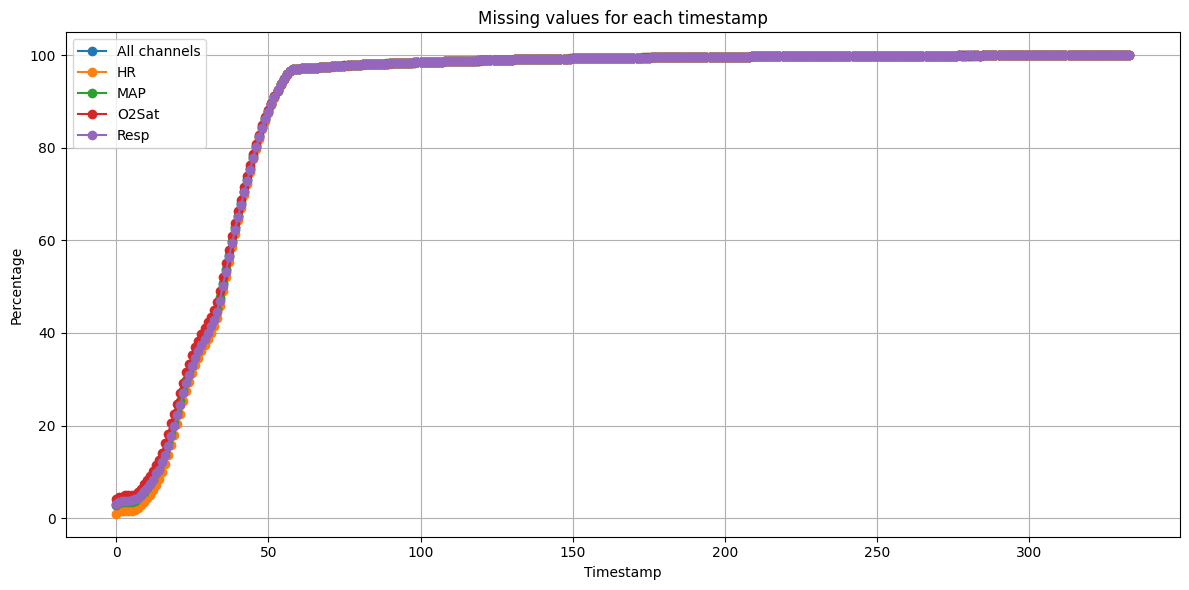

In [79]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train_masked_channels).sum(axis=(0,1))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train_masked_channels.shape[0] * X_train_masked_channels.shape[1])) * 100
print("Percentage of missing values in timestamps:")
print(missing_percentage)

# Compute the nan counts for each timestamp
missing_vals_channels = np.isnan(X_train_masked_channels).sum(axis=(0))
# Compute the percentage of missing values for each timestamp
missing_percentage_channels = (missing_vals_channels / (X_train_masked_channels.shape[0])) * 100
print("Percentage of missing values in timestamps:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.plot(missing_percentage, marker="o", linestyle="-", label="All channels")
plt.plot(missing_percentage_channels.T, marker="o", linestyle="-", label=label_masked_channels)
plt.xlabel("Timestamp")
plt.ylabel("Percentage")
plt.grid(axis="both")
plt.title("Missing values for each timestamp")
plt.legend()
plt.tight_layout()
plt.show()

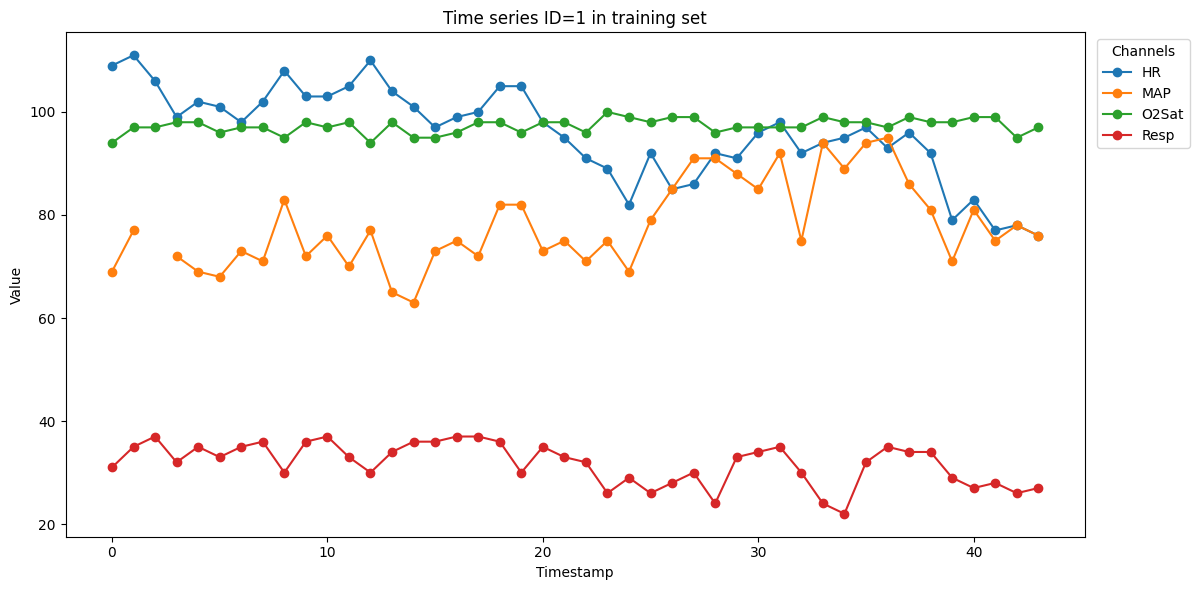

In [80]:
# Plot a time series with the labels
plt.figure(figsize=(12, 6))
plt.plot(X_train_masked_channels[sample, :, :].T, marker="o", linestyle="-", label=label_masked_channels)
plt.title(f"Time series ID={sample} in training set")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.11, 1),
    fontsize=10,
    title="Channels",
    title_fontsize=10
    )
plt.tight_layout()
plt.show()

### Cutoff timestamps

Percentage of missing values in timestamps:
[ 2.78692958  3.20982494  3.3893096   3.48765736  3.38808025  3.51716168
  3.6536192   4.14289929  4.76371951  5.58861133  6.35449449  7.25929386
  8.29194532  9.54096184 10.65597954 12.22462628 13.97152832 15.87701613
 18.13532651 20.29283045 22.57081039 24.79469906 27.32838316 29.52276751
 31.33974233 33.21572581 34.92574744 36.44890834 37.82085956 39.122738
 40.40863493 41.71543076 43.14147325 44.9068155  47.35690401 50.58148112
 53.53928993 56.62740952 59.69094217 62.57621951 65.27217742 67.84397128
 70.55468135 73.04533832 75.51509638 78.03771637 80.30709087 82.3883753
 84.48932927 86.20672699 87.83192368 89.47924862 91.05527144 92.39280094
 93.7082022  94.89206334 95.86078875 96.59839693 96.99670535 97.06309009
 97.09259441 97.17619001 97.24626279 97.28928993 97.3015834  97.31141817
 97.33723446 97.38763769 97.43558222 97.48844414 97.53638867 97.58556255
 97.59785602 97.69251574 97.72447876 97.75890047 97.78471676 97.84618411
 97.879376

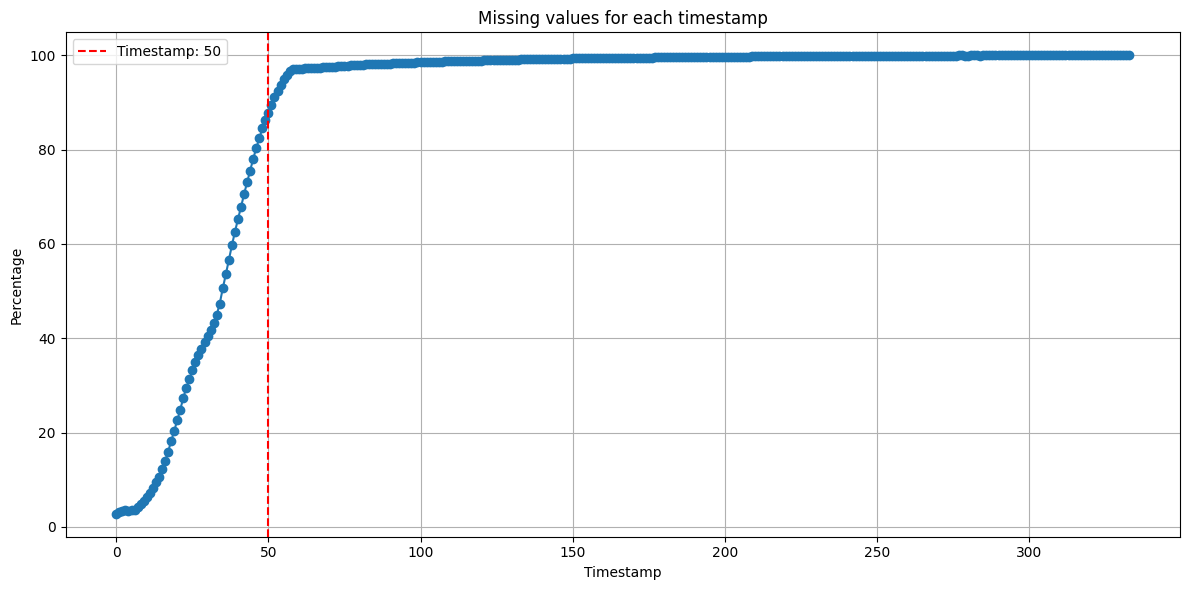

In [81]:
# Compute the nan counts for each timestamp
missing_counts_timestamps = np.isnan(X_train_masked_channels).sum(axis=(0,1))
# Compute the percentage of missing values for each timestamp
missing_percentage_timestamps = (missing_counts_timestamps / (X_train_masked_channels.shape[0] * X_train_masked_channels.shape[1])) * 100
print("Percentage of missing values in timestamps:")
print(missing_percentage_timestamps)

# cutoff_timestamps = 13

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.plot(missing_percentage_timestamps, marker="o", linestyle="-")
plt.axvline(cutoff_timestamps, color="red", linestyle="--", label=f"Timestamp: {cutoff_timestamps}")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Percentage")
plt.title("Missing values for each timestamp")
plt.grid(axis="both")
plt.tight_layout()
plt.show()

In [82]:
# Cut the time series at the specified timestamp
X_train_masked_channels_cutoff = X_train_masked_channels[:, :, :cutoff_timestamps]
X_test_masked_channels_cutoff = X_test_masked_channels[:, :, :cutoff_timestamps]

In [83]:
print("Original Train data shape:")
print("Input: ", X_train.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape (without useless channels):")
print("Input: ", X_train_masked_channels.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape (without useless channels and cutoff):")
print("Input: ", X_train_masked_channels_cutoff.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Original Test data shape:")
print("Input: ", X_test.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)
print("\n")
print("Test data shape (without useless channels and cutoff):")
print("Input: ", X_test_masked_channels_cutoff.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)

Original Train data shape:
Input:  (20336, 34, 334)
Label:  (20336,)


Train data shape (without useless channels):
Input:  (20336, 4, 334)
Label:  (20336,)


Train data shape (without useless channels and cutoff):
Input:  (20336, 4, 50)
Label:  (20336,)


Original Test data shape:
Input:  (19998, 34, 334)
Label:  (19998,)


Test data shape (without useless channels and cutoff):
Input:  (19998, 4, 50)
Label:  (19998,)


Percentage of missing values in samples:
[58.5 12.5 19.5 ... 10.5 67.  26.5]


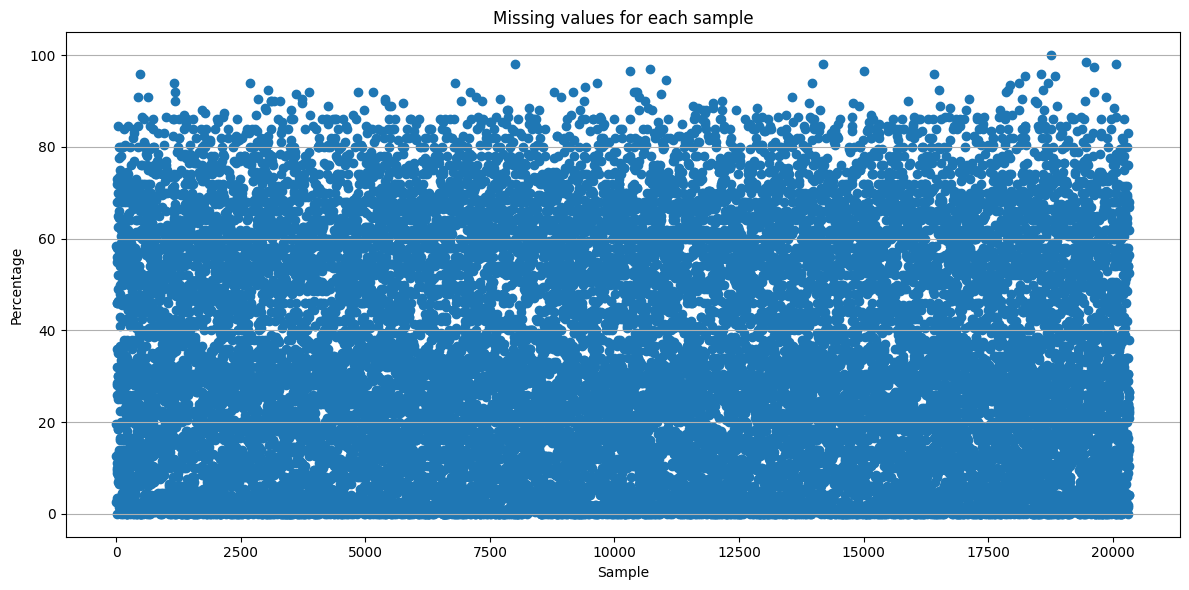

In [84]:
# Compute the nan counts for each timestamp
missing_vals = np.isnan(X_train_masked_channels_cutoff).sum(axis=(1,2))
# Compute the percentage of missing values for each timestamp
missing_percentage = (missing_vals / (X_train_masked_channels_cutoff.shape[1] * X_train_masked_channels_cutoff.shape[2])) * 100
print("Percentage of missing values in samples:")
print(missing_percentage)

# plot the distribution of missing values keeping the order of the timestamps
plt.figure(figsize=(12, 6))
plt.scatter(
    np.arange(len(missing_percentage)),
    missing_percentage,
)
plt.xlabel("Sample")
plt.ylabel("Percentage")
plt.title("Missing values for each sample")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

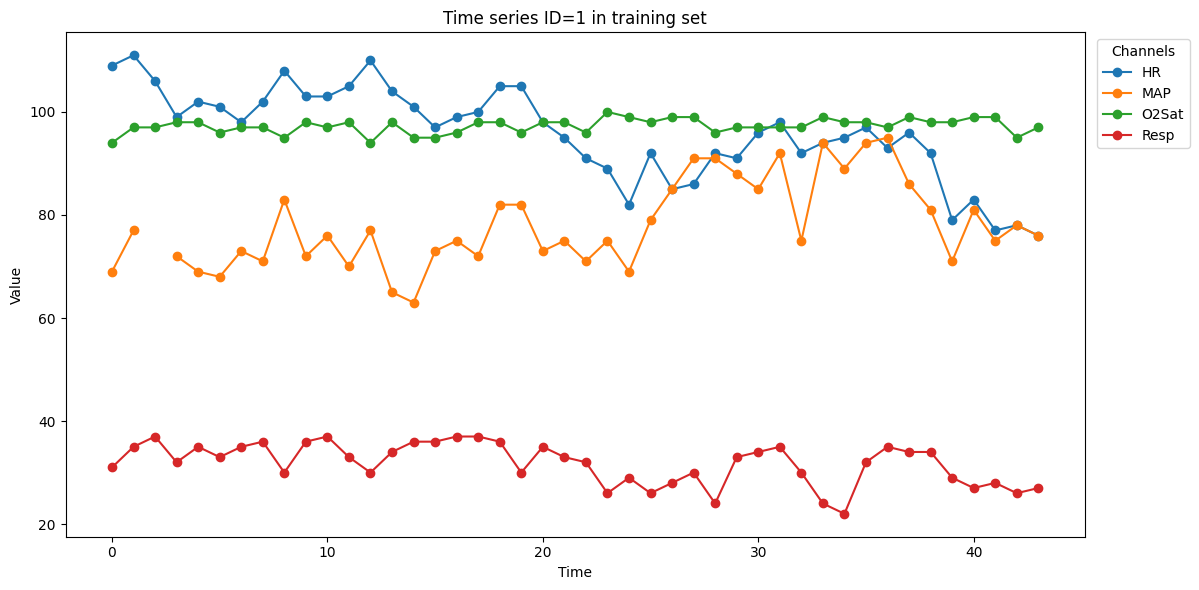

In [85]:
# Plot a time series with the labels
plt.figure(figsize=(12, 6))
plt.plot(X_train_masked_channels_cutoff[sample, :, :].T, marker="o", linestyle="-", label=label_masked_channels)
plt.title(f"Time series ID={sample} in training set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.11, 1),
    fontsize=10,
    title="Channels",
    title_fontsize=10
    )
plt.tight_layout()
plt.show()

### Remove useless samples

Percentage of missing values in samples:
[58.5 12.5 19.5 ... 10.5 67.  26.5]


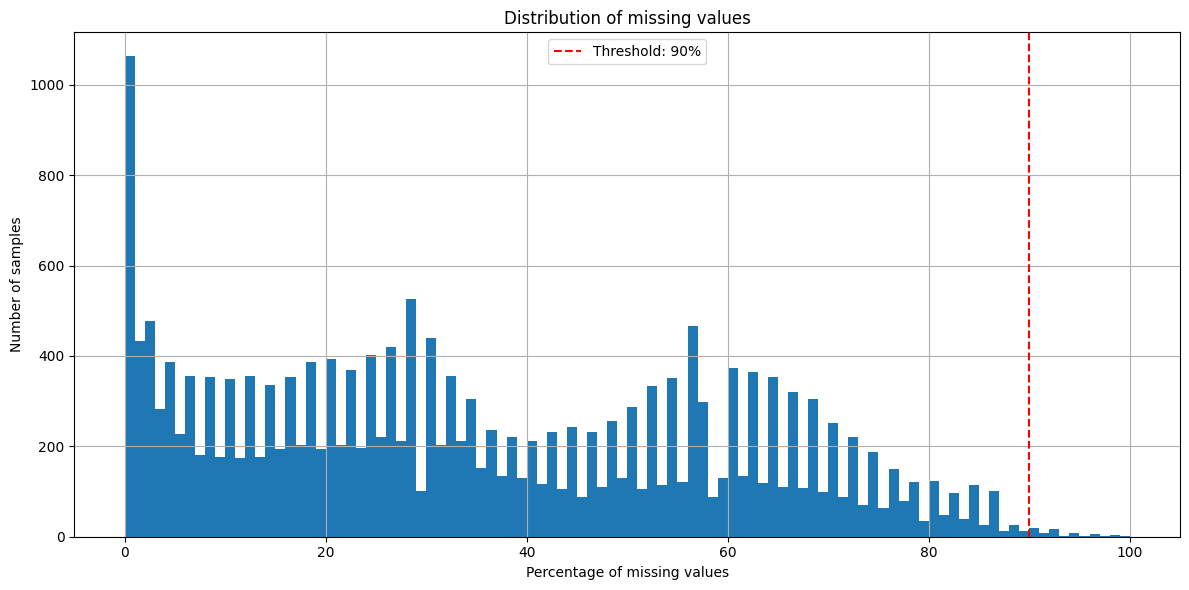

In [86]:
# Compute the percentage of missing values for each feature
missing_counts_samples = np.isnan(X_train_masked_channels_cutoff).sum(axis=(1,2))
missing_percentage_samples = (missing_counts_samples / (X_train_masked_channels_cutoff.shape[1] * X_train_masked_channels_cutoff.shape[2])) * 100
print("Percentage of missing values in samples:")
print(missing_percentage_samples)

# threshold_samples = 20

plt.figure(figsize=(12,6))
plt.hist(missing_percentage_samples, bins=100)
plt.axvline(threshold_samples, color="red", linestyle="--", label=f"Threshold: {threshold_samples}%")
plt.legend()
plt.xlabel("Percentage of missing values")
plt.ylabel("Number of samples")
plt.title("Distribution of missing values")
plt.grid(axis="both")
plt.tight_layout()
plt.show()

In [87]:
# drop samples with more than treshold% of missing values
mask_samples = missing_percentage_samples < threshold_samples
X_train_masked_channels_cutoff_samples = X_train_masked_channels_cutoff[mask_samples, :, :]
y_train_masked_samples = y_train_labelled[mask_samples]

In [88]:
# check the shape of the masked data
print("Original Train data shape:")
print("Input: ", X_train.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape (without useless channels):")
print("Input: ", X_train_masked_channels.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape (without useless channels and cutoff):")
print("Input: ", X_train_masked_channels_cutoff.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train.shape)  # (n_samples,)
print("\n")
print("Train data shape (without useless channels, cutoff and samples):")
print("Input: ", X_train_masked_channels_cutoff_samples.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_train_masked_samples.shape)  # (n_samples,)
print("\n")
print("Original Test data shape:")
print("Input: ", X_test.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)
print("\n")
print("Test data shape (without useless channels and cutoff):")
print("Input: ", X_test_masked_channels_cutoff.shape)  # (n_samples, n_channels, n_timestamps)
print("Label: ", y_test.shape)  # (n_samples,)

Original Train data shape:
Input:  (20336, 34, 334)
Label:  (20336,)


Train data shape (without useless channels):
Input:  (20336, 4, 334)
Label:  (20336,)


Train data shape (without useless channels and cutoff):
Input:  (20336, 4, 50)
Label:  (20336,)


Train data shape (without useless channels, cutoff and samples):
Input:  (20267, 4, 50)
Label:  (20267,)


Original Test data shape:
Input:  (19998, 34, 334)
Label:  (19998,)


Test data shape (without useless channels and cutoff):
Input:  (19998, 4, 50)
Label:  (19998,)


y_train_masked_samples:
(array([0, 1]), array([18485,  1782])) 

y_train_masked_samples labels percentage:
[91.20738146  8.79261854]


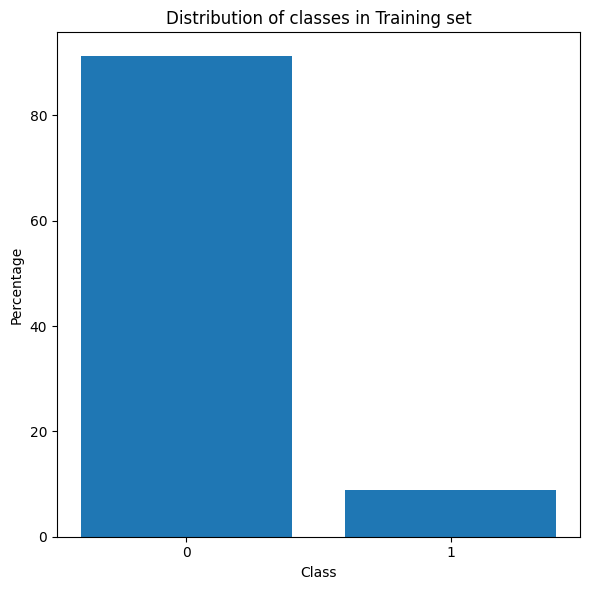

In [89]:
print("y_train_masked_samples:")
print(np.unique(y_train_masked_samples, return_counts=True), "\n")
print("y_train_masked_samples labels percentage:")
print(np.unique(y_train_masked_samples, return_counts=True)[1] / len(y_train_masked_samples) * 100)

plt.figure(figsize=(6, 6))
plt.bar(
    np.unique(y_train_masked_samples),
    np.unique(y_train_masked_samples, return_counts=True)[1] / len(y_train_masked_samples) * 100,
)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(
    np.arange(len(np.unique(y_train_masked_samples))),
    np.unique(y_train_masked_samples),
)
plt.title("Distribution of classes in Training set")
plt.tight_layout()
plt.show()

### Check

In [90]:
# compute the indices of the timeseries with all nan values
def compute_all_nan_samples(data):
    """
    Input:
        data: np.ndarray of shape (n_samples, n_channels, n_timestamps)
    Output:
        indices: np.ndarray of shape (n_samples,) with the indices of the samples with all NaN values
    """
    all_nan_samples = np.isnan(data).all(axis=(1, 2))  # shape: (n_samples,)
    return np.where(all_nan_samples)[0]

all_nan_samples_train = compute_all_nan_samples(X_train_masked_channels_cutoff_samples)
print("Indices of all NaN time series in train set:", all_nan_samples_train)

Indices of all NaN time series in train set: []


In [91]:
def compute_any_nan_channels(data):
    """
    The function computes the indices of samples that have
    at least one channel with all NaN values across the entire time axis.
    Input:
        data: np.ndarray of shape (n_samples, n_channels, n_timestamps)
    Output:
        indices: np.ndarray of shape (n_samples,) with the indices of the samples with at least one channel with all NaN values
    """
    # Find where values are NaN
    nan_mask = np.isnan(data)  # shape: (n_samples, n_channels, n_timestamps)

    # Check for each (sample, channel) if all timestamps are NaN
    all_nan_per_channel = np.all(nan_mask, axis=2)  # shape: (n_samples, n_channels)

    # Now for each sample, check if any channel is all NaN
    has_any_nan_channel = np.any(all_nan_per_channel, axis=1)  # shape: (n_samples,)
    
    return np.where(has_any_nan_channel)[0]

any_nan_channel_indices_train = compute_any_nan_channels(X_train_masked_channels_cutoff_samples)
print("Indices of time series with any NaN channels in train set:", any_nan_channel_indices_train)

Indices of time series with any NaN channels in train set: [ 1997  2234  2842  2920  3139  5650  6938  7158  7782  7824  7829  7834
  8175  8249  9266  9276  9340 10051 10213 10448 10497 10686 10910 11085
 12790 12913 13185 13664 13885 14011 14055 14224 14260 19948]


In [ ]:
# Fill the fully nan channels with the mean of the other channels
mean_channels = np.nanmean(X_train_masked_channels_cutoff_samples, axis=(0, 2))  # shape: (n_channels,)
X_train_masked_channels_cutoff_samples_filled = X_train_masked_channels_cutoff_samples.copy()
for i in range(X_train_masked_channels_cutoff_samples.shape[0]):
    for j in range(X_train_masked_channels_cutoff_samples.shape[1]):
        if np.isnan(X_train_masked_channels_cutoff_samples[i, j, :]).all():
            X_train_masked_channels_cutoff_samples_filled[i, j, :] = mean_channels[j]

In [93]:
print("Number of missing values in train set:")
print(np.isnan(X_train_masked_channels_cutoff_samples_filled).ravel().sum())
print("\n")
print("Percentage of missing values in train set:")
print(np.isnan(X_train_masked_channels_cutoff_samples_filled).ravel().sum() / X_train_masked_channels_cutoff_samples.size * 100)

Number of missing values in train set:
1402382


Percentage of missing values in train set:
34.597671090936004


### Imputing missing values in Train set

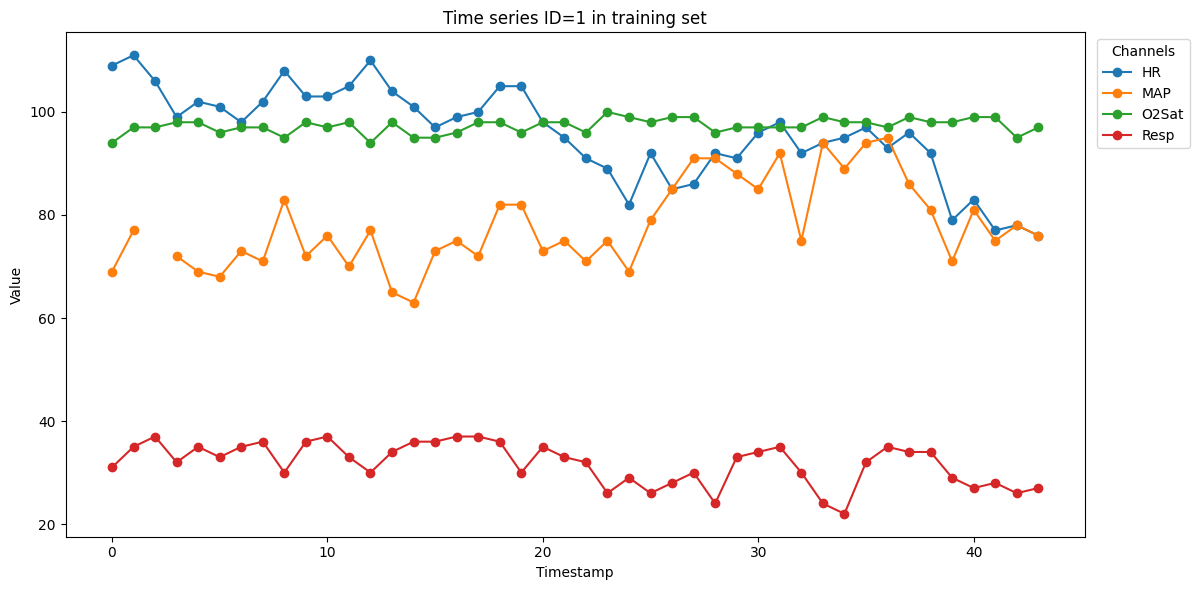

In [94]:
# Plot a time series
plt.figure(figsize=(12, 6))
plt.plot(X_train_masked_channels_cutoff_samples_filled[sample, :, :].T, marker="o", linestyle="-",label=label_masked_channels)
plt.title(f"Time series ID={sample} in training set")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.11, 1),
    fontsize=10,
    title="Channels",
    title_fontsize=10
    )
plt.tight_layout()
plt.show()

In [95]:
# replace missing values in training set
imputer = Imputer(method="drift")  # try "drift"

X_train_imputed = imputer.fit_transform(X_train_masked_channels_cutoff_samples_filled)
y_train_imputed = y_train_masked_samples
X_train_imputed.shape, y_train_imputed.shape

((20267, 4, 50), (20267,))

In [96]:
# check if there are still missing values
print("Number of missing values in train set after imputation:")
print(np.isnan(X_train_imputed).ravel().sum())

Number of missing values in train set after imputation:
0


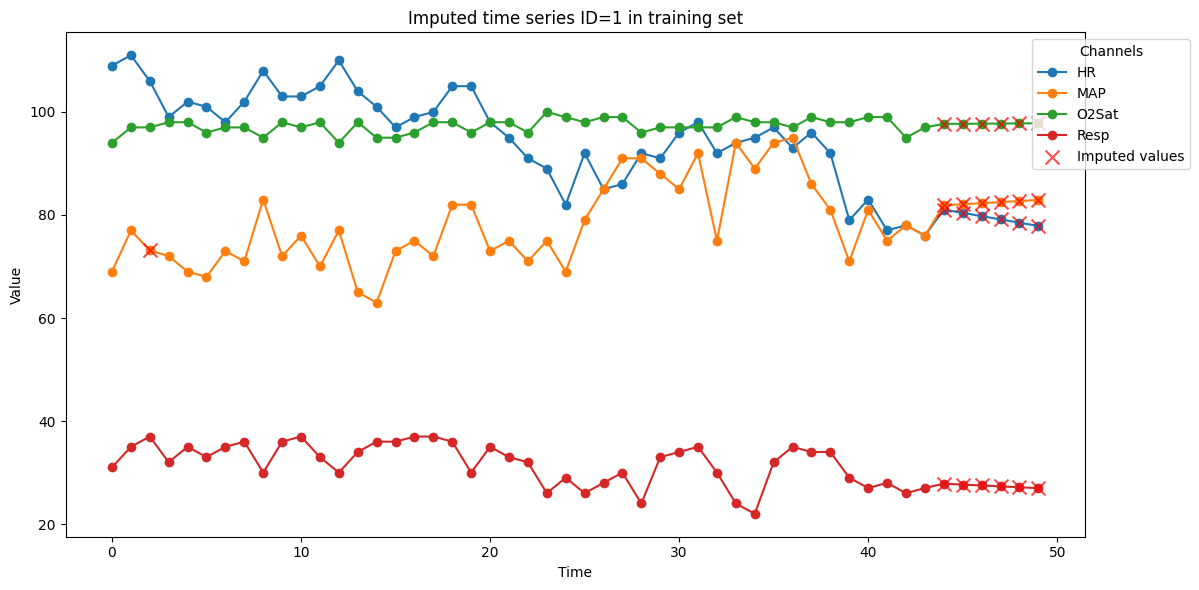

In [97]:
# Plot a time series
plt.figure(figsize=(12, 6))

plt.plot(
    X_train_imputed[sample, :, :].T,
    marker="o",
    linestyle="-",
    label=label_masked_channels,
    zorder=1  # lower zorder for lines
)

# Plot the imputed values above the lines
nan_indices = np.isnan(X_train_masked_channels_cutoff_samples_filled[sample, :, :])
imputed_values = X_train_imputed[sample, :, :].copy()
imputed_values[~nan_indices] = np.nan
plt.scatter(
    np.broadcast_to(np.arange(imputed_values.shape[-1]), imputed_values.shape),
    imputed_values,
    marker="x",
    s=100,
    color="red",
    label="Imputed values",
    alpha=0.7,
    zorder=2  # higher zorder for scatter
)
plt.title(f"Imputed time series ID={sample} in training set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.11, 1),
    fontsize=10,
    title="Channels",
    title_fontsize=10
)
plt.tight_layout()
plt.show()

### Imputing the missing values in Test set

In [98]:
sample_ts = 4

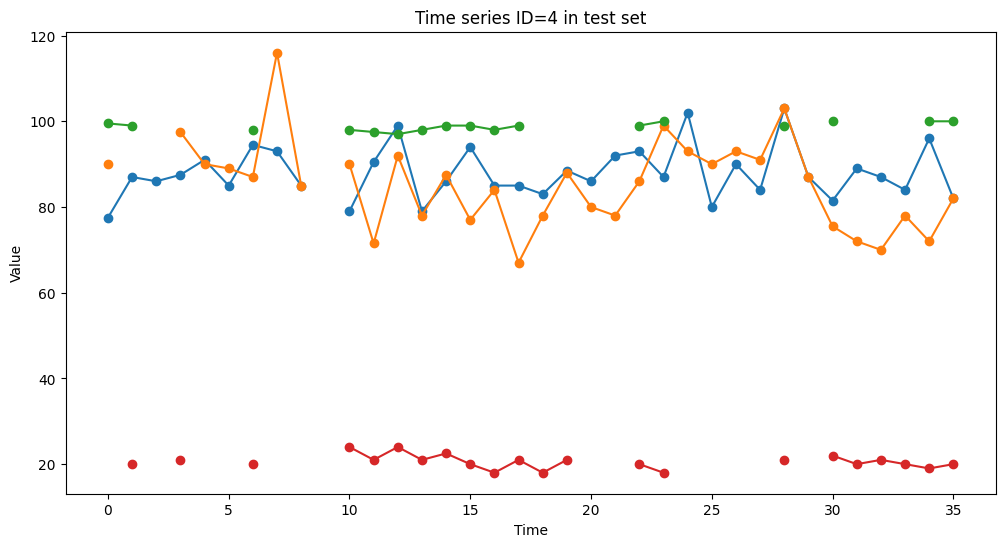

In [99]:
# Plot a time series
plt.figure(figsize=(12, 6))
plt.plot(X_test_masked_channels_cutoff[sample_ts, :, :].T, marker="o", linestyle="-")
plt.title(f"Time series ID={sample_ts} in test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [100]:
print("Number of missing values in test set:")
print(np.isnan(X_test_masked_channels_cutoff).ravel().sum())

Number of missing values in test set:
1605578


Mean values for each channel in train set:
[84.36841447 78.39021886 96.97923764 18.75971765]


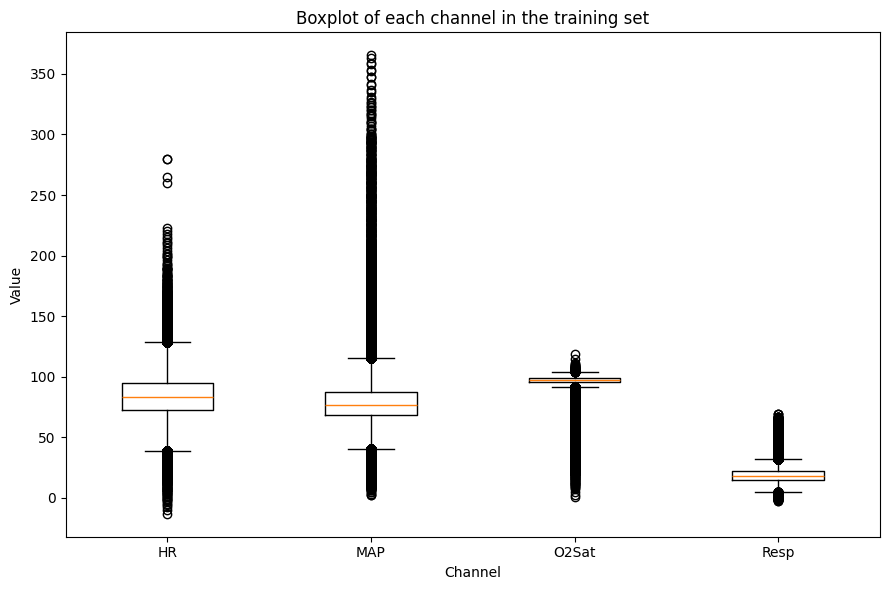

In [101]:
# Compute the mean value for each channel
mean_values = np.nanmean(X_train_imputed, axis=(0, 2))
print("Mean values for each channel in train set:")
print(mean_values)

# Assuming X_train_imputed has shape (n_samples, n_channels, n_timestamps)
_, n_channels, _ = X_train_imputed.shape

# Reshape to (n_channels, n_samples * n_timestamps) so each channel is a row of values
channel_data = X_train_imputed.transpose(1, 0, 2).reshape(n_channels, -1)

# Create the boxplot (vertical)
plt.figure(figsize=(9, 6))
plt.boxplot(channel_data.T)  # each column is a channel now
plt.title("Boxplot of each channel in the training set")
plt.ylabel("Value")
plt.xlabel("Channel")
plt.xticks(np.arange(1, n_channels + 1), labels=label_masked_channels, rotation=0)
plt.tight_layout()
plt.show()

In [102]:
# Fill the missing values in the test set with the mean values
X_test_imputed = X_test_masked_channels_cutoff.copy()
for i in range(X_test_imputed.shape[1]):
    X_test_imputed[:, i, :][np.isnan(X_test_imputed[:, i, :])] = mean_values[i]

y_test_imputed = y_test.copy()

In [103]:
print("Imputed Test data shape:")
print(X_test_imputed.shape)
print(y_test_imputed.shape)
print("\n")
# check if there are still missing values
print("Number of missing values in test set after imputation:")
print(np.isnan(X_test_imputed).ravel().sum())

Imputed Test data shape:
(19998, 4, 50)
(19998,)


Number of missing values in test set after imputation:
0


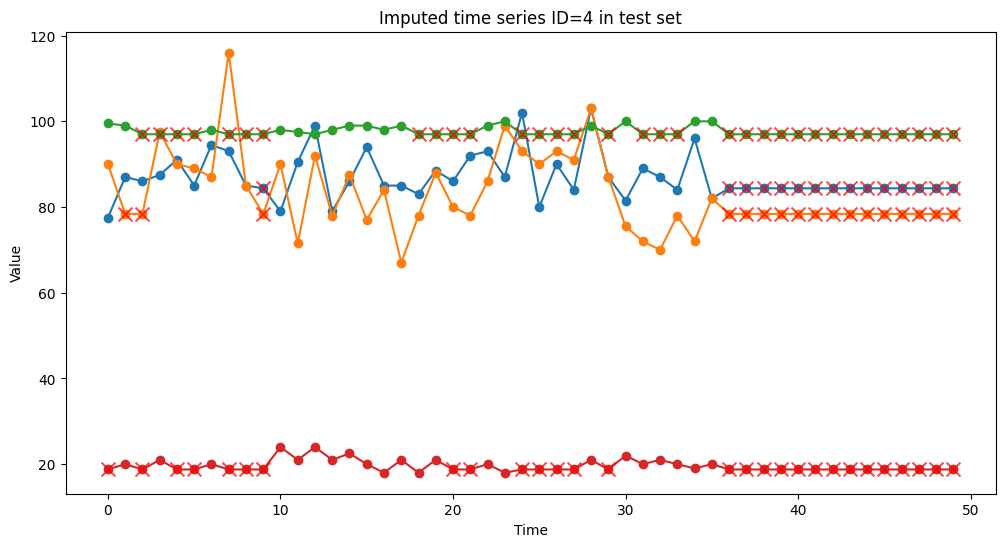

In [104]:
# Plot a time series
plt.figure(figsize=(12, 6))
plt.plot(X_test_imputed[4, :, :].T, marker="o", linestyle="-")
# Plot the imputed values above the lines
nan_indices = np.isnan(X_test_masked_channels_cutoff[sample_ts, :, :])
imputed_values = X_test_imputed[sample_ts, :, :].copy()
imputed_values[~nan_indices] = np.nan
plt.scatter(
    np.broadcast_to(np.arange(imputed_values.shape[-1]), imputed_values.shape),
    imputed_values,
    marker="x",
    s=100,
    color="red",
    label="Imputed values",
    alpha=0.7,
    zorder=2  # higher zorder for scatter
)
plt.title(f"Imputed time series ID={sample_ts} in test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

## Libraries for ML

In [68]:
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pandas as pd

## Euclidean KNN

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

model_label = "euknn"

n_neighbors_list = [3, 5, 7]
distances_list = ["euclidean"]

grid = GridSearchCV(
    estimator= scaler * KNeighborsTimeSeriesClassifier(distance=distances_list[0]),
    param_grid={"n_neighbors": n_neighbors_list, "distance": distances_list},
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="f1",
    verbose=4,
    n_jobs=1,
)

grid.fit(X_train_imputed, y_train_imputed)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


KeyboardInterrupt: 

In [ ]:
grid.best_params_

{'distance': 'euclidean', 'n_neighbors': 3}

In [ ]:
best_df = pd.DataFrame(grid.cv_results_)
best_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_distance,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.248210,1.179572,16.211469,0.702890,euclidean,3,"{'distance': 'euclidean', 'n_neighbors': 3}",0.777778,0.774362,0.777632,0.776591,0.001577,1
1,15.535747,0.079695,15.192738,0.469758,euclidean,5,"{'distance': 'euclidean', 'n_neighbors': 5}",0.777778,0.774362,0.777632,0.776591,0.001577,1
2,15.254138,0.973926,15.363933,0.533720,euclidean,7,"{'distance': 'euclidean', 'n_neighbors': 7}",0.777778,0.774362,0.777632,0.776591,0.001577,1


In [ ]:
grid.best_estimator_.fit(X_train_imputed, y_train_imputed)

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(distance='euclidean'),
                   transformers=[TabularToSeriesAdaptor(fit_in_transform=True,
                                                        transformer=StandardScaler())])

In [ ]:
y_pred = grid.best_estimator_.predict(X_test_imputed)

## CNN

In [70]:
from sktime.classification.deep_learning import CNNClassifier

model_label = "cnn"

param_grid = {
    "n_epochs" : [100],
    "batch_size" : [16],
    "kernel_size" : [3],
    "avg_pool_size" : [3],
    "n_conv_layers" : [2],
    "loss" : ["categorical_crossentropy"],
    "activation" : ["softmax"],
    "use_bias": [True],
    "padding" : ["auto"]
}

grid = GridSearchCV(
    estimator= scaler * CNNClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="f1",
    verbose=4,
    n_jobs=1,  # -1 for all cores
)

grid.fit(X_train_imputed, y_train_imputed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025-04-25 01:32:32.453361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745537552.627082    7856 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745537552.680877    7856 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745537553.128568    7856 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745537553.128585    7856 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745537553.128587    7856 computation_placer.cc:177] computation placer alr

KeyboardInterrupt: 

In [ ]:
grid.best_params_

{'activation': 'softmax',
 'avg_pool_size': 3,
 'batch_size': 8,
 'kernel_size': 3,
 'loss': 'categorical_crossentropy',
 'n_conv_layers': 1,
 'n_epochs': 5,
 'padding': 'auto',
 'use_bias': True}

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_avg_pool_size,param_batch_size,param_kernel_size,param_loss,param_n_conv_layers,param_n_epochs,param_padding,param_use_bias,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,136.571526,1.287909,1.085227,0.018162,softmax,3,8,3,categorical_crossentropy,1,5,auto,True,"{'activation': 'softmax', 'avg_pool_size': 3, ...",0.756614,0.783069,0.756614,0.765432,0.012471,1


In [ ]:
grid.best_estimator_.fit(X_train_imputed, y_train_imputed)

ClassifierPipeline(classifier=CNNClassifier(),
                   transformers=[TabularToSeriesAdaptor(fit_in_transform=True,
                                                        transformer=StandardScaler())])

In [ ]:
y_pred = grid.best_estimator_.predict(X_test_imputed)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step


## Rocket

In [ ]:
from sktime.transformations.compose import OptionalPassthrough
from sktime.classification.kernel_based import RocketClassifier

model_label = "rocket"

param_grid = {
    "optionalpassthrough__passthrough": [True, False],
    "rocketclassifier__rocket_transform": ['rocket', 'minirocket'],
}

grid = GridSearchCV(
    estimator=OptionalPassthrough(scaler) * RocketClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="f1",
    verbose=4,
    n_jobs=2,  # -1 for all cores
)

In [ ]:
grid.fit(X_train_imputed, y_train_imputed)
grid.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


{'optionalpassthrough__passthrough': False,
 'rocketclassifier__rocket_transform': 'minirocket'}

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optionalpassthrough__passthrough,param_rocketclassifier__rocket_transform,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,30.280857,0.537537,10.104359,0.621209,True,rocket,"{'optionalpassthrough__passthrough': True, 'ro...",0.851852,0.851852,0.825397,0.843034,0.012471,3
1,29.323382,1.327332,9.223600,0.076535,True,minirocket,"{'optionalpassthrough__passthrough': True, 'ro...",0.862434,0.846561,0.830688,0.846561,0.012960,2
2,29.089595,0.166736,8.972299,0.789688,False,rocket,"{'optionalpassthrough__passthrough': False, 'r...",0.851852,0.830688,0.825397,0.835979,0.011430,4
3,30.169914,0.621336,9.473194,0.416894,False,minirocket,"{'optionalpassthrough__passthrough': False, 'r...",0.862434,0.846561,0.835979,0.848325,0.010872,1


In [ ]:
grid.best_estimator_.fit(X_train_imputed, y_train_imputed)
y_pred = grid.best_estimator_.predict(X_test_imputed)

## Catch + RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.panel.catch22 import Catch22

model_label = "catch22+rf"

param_grid = {
    "catch22__catch24": [False],
    "randomforestclassifier__n_estimators": [5, 10]
}

grid = GridSearchCV(
    estimator=Catch22() * RandomForestClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="f1",
    verbose=4,
    n_jobs=-1,
)

grid.fit(X_train_imputed, y_train_imputed)
grid.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'catch22__catch24': False, 'randomforestclassifier__n_estimators': 10}

In [50]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_catch22__catch24,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,275.964986,1.967225,158.908688,1.382394,False,5,"{'catch22__catch24': False, 'randomforestclass...",0.857516,0.858077,0.858077,0.857890,0.000264,2
1,279.159216,1.812530,156.732941,0.303087,False,10,"{'catch22__catch24': False, 'randomforestclass...",0.858170,0.858077,0.859385,0.858544,0.000596,1


In [ ]:
grid.best_estimator_.fit(X_train_imputed, y_train_imputed)
y_pred = grid.best_estimator_.predict(X_test_imputed)

## Submit dummy

In [ ]:
def prepare_submission(ids, pred):
    submission = pd.DataFrame({"ID": ids, "TARGET": pred})
    return submission

In [20]:
from sktime.classification.dummy import DummyClassifier

In [21]:
clf = DummyClassifier()

In [22]:
%%time
clf.fit(X_train, y_train)

CPU times: user 24.7 s, sys: 572 ms, total: 25.3 s
Wall time: 25.5 s


DummyClassifier()

In [23]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 25.9 s, sys: 553 ms, total: 26.4 s
Wall time: 26.5 s


In [27]:
submission = prepare_submission(test_id, y_pred)
submission.to_csv("submission_GL_dummy.csv", index=False)

In [28]:
submission.head()

,ID,TARGET
0,0,0.0
1,2,0.0
2,5,0.0
3,7,0.0
4,8,0.0


## Submit

In [48]:
def submit(ids, pred, label):
    submission = pd.DataFrame({"ID": ids, "TARGET": pred})
    submission.to_csv(f"GL_{label}.csv", index=False)
    print(f"Submission file {label} created.")

submit(ids=test_id, pred=y_pred, label=model_label)

Submission file euknn created.
